# Nomor 1 Faces recognition example using eigenfaces and SVMs

In [ ]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print(f"n_samples: {n_samples}")
print(f"n_features: {n_features}")
print(f"n_classes: {n_classes}")

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
n_components = 150

print(f"Extracting the top {n_components} eigenfaces from {X_train.shape[0]} faces")

t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print(f"done in {time() - t0: 0.3f}s")

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"done in {time() - t0: 0.3f}s")

Extracting the top 150 eigenfaces from 966 faces
done in  0.363s
Projecting the input data on the eigenfaces orthonormal basis
done in  0.036s


In [ ]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print(f"done in {time() - t0: 0.3f}s")
print(f"Best estimator found by grid search: \n{clf.best_estimator_}")

Fitting the classifier to the training set
done in  14.328s
Best estimator found by grid search: 
SVC(C=8735.898419784842, class_weight='balanced', gamma=0.0014833043226166137)


Predicting people's names on the test set
done in  0.099s
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.77      0.71        13
     Colin Powell       0.74      0.87      0.80        60
  Donald Rumsfeld       0.75      0.67      0.71        27
    George W Bush       0.91      0.93      0.92       146
Gerhard Schroeder       0.86      0.76      0.81        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.90      0.75      0.82        36

         accuracy                           0.84       322
        macro avg       0.81      0.76      0.78       322
     weighted avg       0.85      0.84      0.84       322



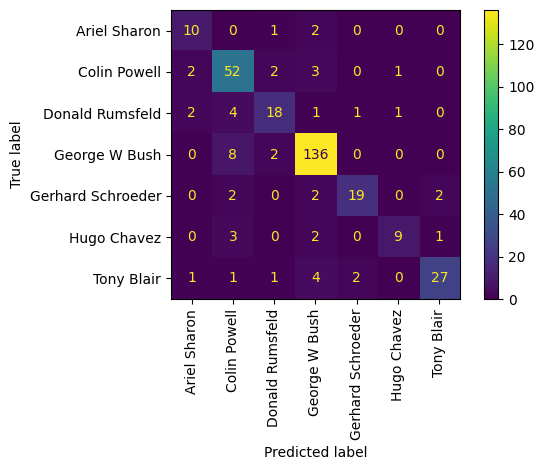

In [ ]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print(f"done in {time() - t0: 0.3f}s")

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [ ]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

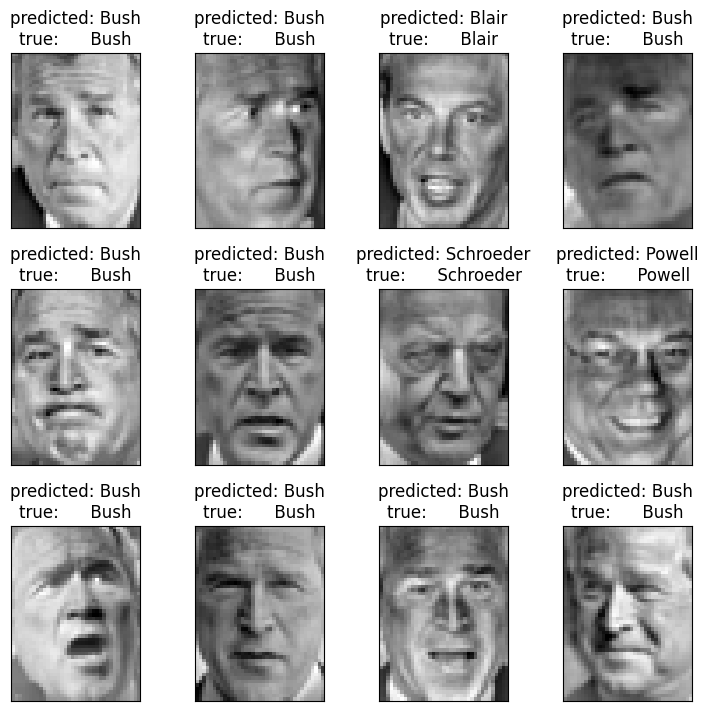

In [ ]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return f"predicted: {pred_name}\ntrue:      {true_name}"


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

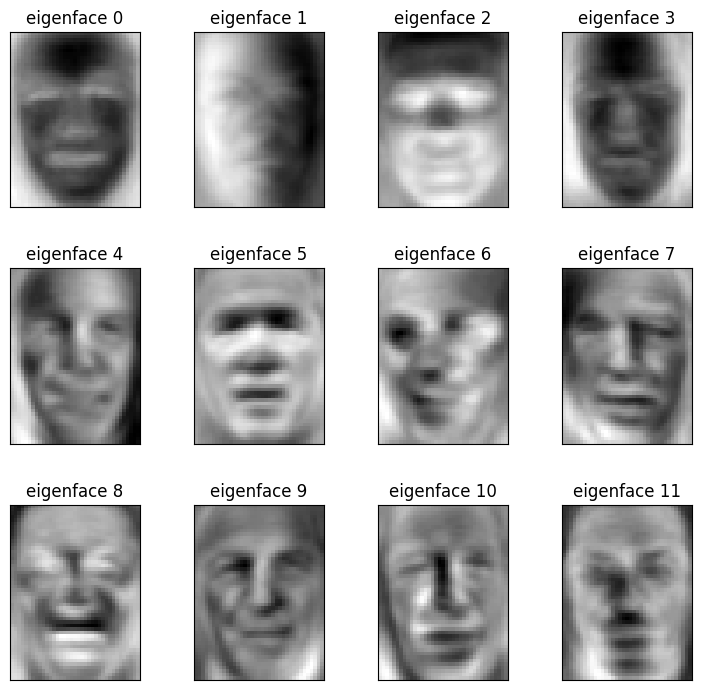

In [ ]:
eigenface_titles = [f"eigenface {i}" for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# Nomor 2 Face Dataset decompositions

## Dataset preparation

In [ ]:
import logging

import matplotlib.pyplot as plt
from numpy.random import RandomState

from sklearn import cluster, decomposition
from sklearn.datasets import fetch_olivetti_faces

rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = faces - faces.mean(axis=0)

# Local centering (focus on one sample, centering all features)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 400 faces


In [ ]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

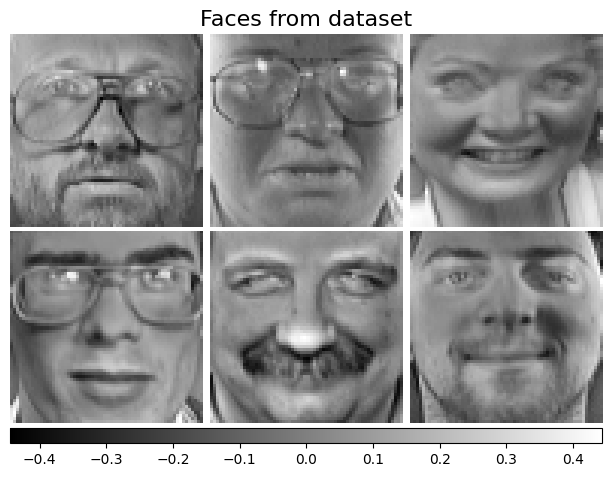

In [ ]:
plot_gallery("Faces from dataset", faces_centered[:n_components])

## Eigenfaces - PCA using randomize SVD

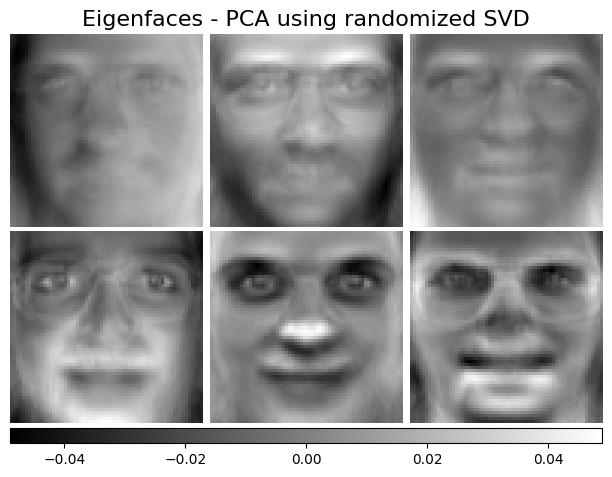

In [ ]:
pca_estimator = decomposition.PCA(
    n_components=n_components, svd_solver="randomized", whiten=True
)
pca_estimator.fit(faces_centered)
plot_gallery(
    "Eigenfaces - PCA using randomized SVD", pca_estimator.components_[:n_components]
)

## Non-negative components - NMF

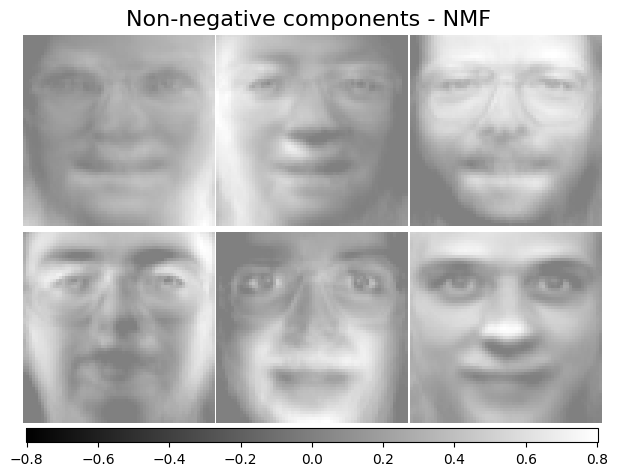

In [ ]:
nmf_estimator = decomposition.NMF(n_components=n_components, tol=5e-3)
nmf_estimator.fit(faces)  # original non- negative dataset
plot_gallery("Non-negative components - NMF", nmf_estimator.components_[:n_components])

## Independent components - FastICA

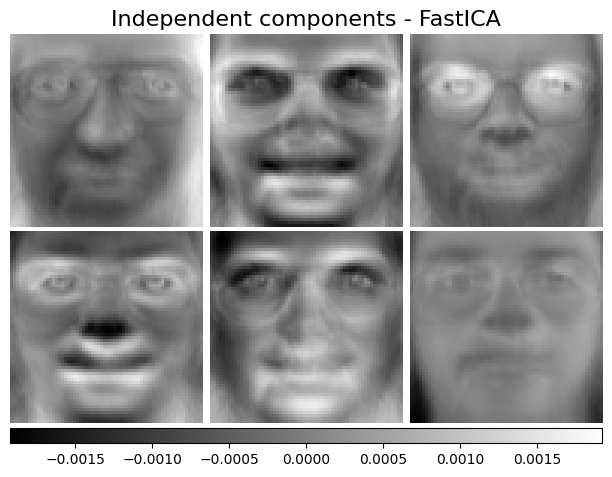

In [ ]:
ica_estimator = decomposition.FastICA(
    n_components=n_components, max_iter=400, whiten="arbitrary-variance", tol=15e-5
)
ica_estimator.fit(faces_centered)
plot_gallery(
    "Independent components - FastICA", ica_estimator.components_[:n_components]
)

## Spaerse components - MiniBatchSparsePCA

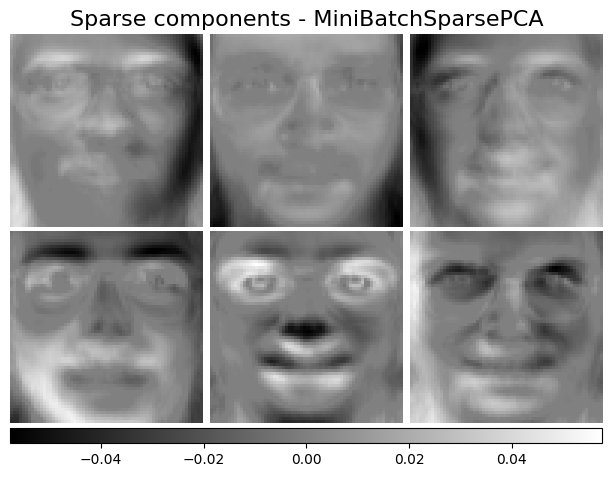

In [ ]:
batch_pca_estimator = decomposition.MiniBatchSparsePCA(
    n_components=n_components, alpha=0.1, max_iter=100, batch_size=3, random_state=rng
)
batch_pca_estimator.fit(faces_centered)
plot_gallery(
    "Sparse components - MiniBatchSparsePCA",
    batch_pca_estimator.components_[:n_components],
)

## Dictionary learning

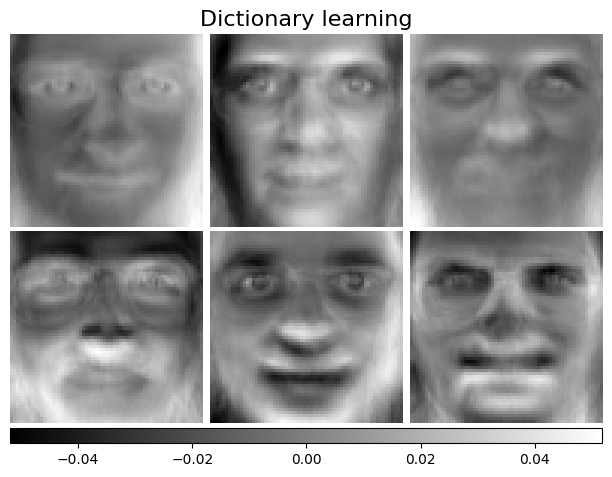

In [ ]:
batch_dict_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components, alpha=0.1, max_iter=50, batch_size=3, random_state=rng
)
batch_dict_estimator.fit(faces_centered)
plot_gallery("Dictionary learning", batch_dict_estimator.components_[:n_components])

## Cluster centers - MiniBatchKMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


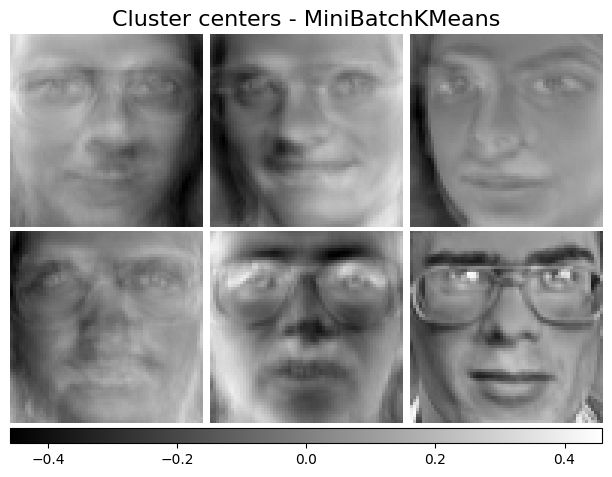

In [ ]:
kmeans_estimator = cluster.MiniBatchKMeans(
    n_clusters=n_components,
    tol=1e-3,
    batch_size=20,
    max_iter=50,
    random_state=rng,
)
kmeans_estimator.fit(faces_centered)
plot_gallery(
    "Cluster centers - MiniBatchKMeans",
    kmeans_estimator.cluster_centers_[:n_components],
)

## Factor Analysis components - FA

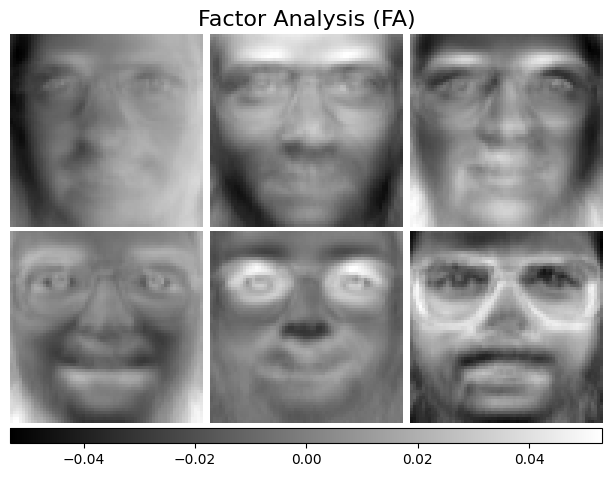

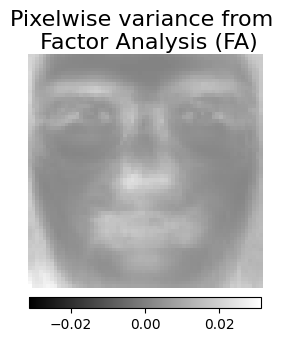

In [ ]:
fa_estimator = decomposition.FactorAnalysis(n_components=n_components, max_iter=20)
fa_estimator.fit(faces_centered)
plot_gallery("Factor Analysis (FA)", fa_estimator.components_[:n_components])

# --- Pixelwise variance
plt.figure(figsize=(3.2, 3.6), facecolor="white", tight_layout=True)
vec = fa_estimator.noise_variance_
vmax = max(vec.max(), -vec.min())
plt.imshow(
    vec.reshape(image_shape),
    cmap=plt.cm.gray,
    interpolation="nearest",
    vmin=-vmax,
    vmax=vmax,
)
plt.axis("off")
plt.title("Pixelwise variance from \n Factor Analysis (FA)", size=16, wrap=True)
plt.colorbar(orientation="horizontal", shrink=0.8, pad=0.03)
plt.show()

## Decomposition: Dictionary learning

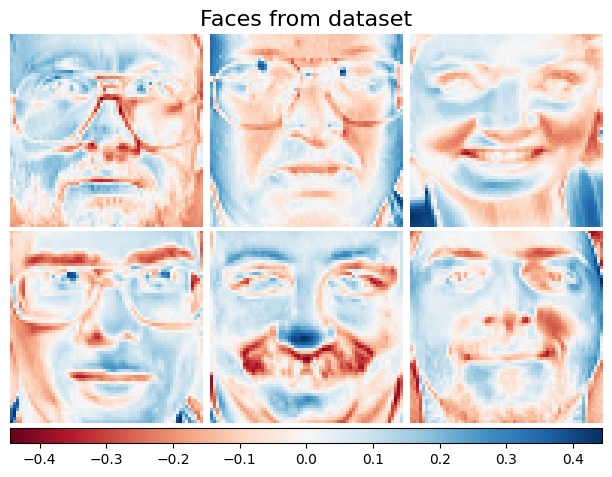

In [ ]:
plot_gallery("Faces from dataset", faces_centered[:n_components], cmap=plt.cm.RdBu)

## Dictionary learning - positive distionary

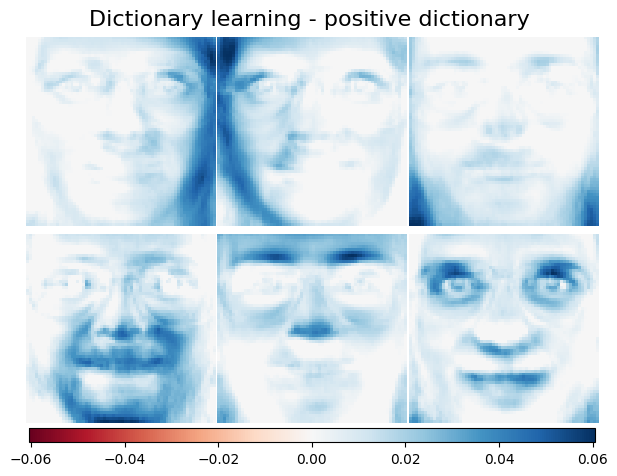

In [ ]:
dict_pos_dict_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    random_state=rng,
    positive_dict=True,
)
dict_pos_dict_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive dictionary",
    dict_pos_dict_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

## Dictionary learning - positive code

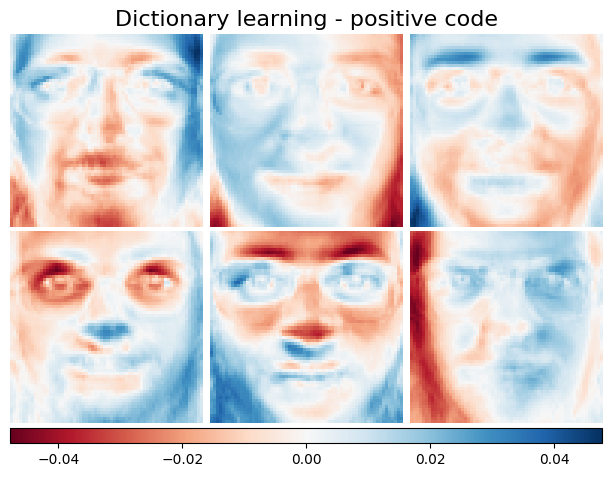

In [ ]:
dict_pos_code_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    fit_algorithm="cd",
    random_state=rng,
    positive_code=True,
)
dict_pos_code_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive code",
    dict_pos_code_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

## Dictionary learning - positive dictionary & code

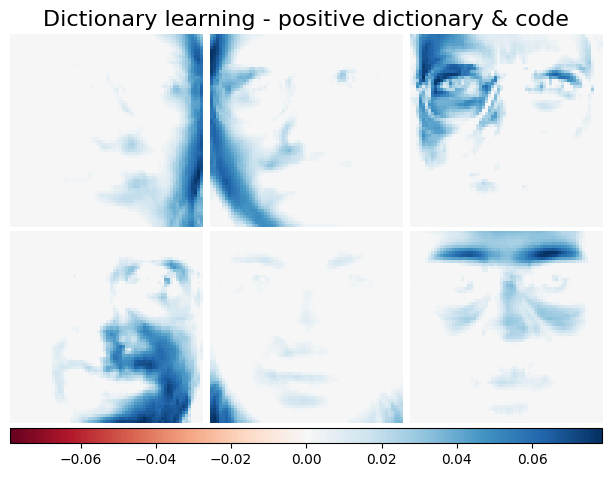

In [ ]:
dict_pos_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    fit_algorithm="cd",
    random_state=rng,
    positive_dict=True,
    positive_code=True,
)
dict_pos_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive dictionary & code",
    dict_pos_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

# Nomor 3 Incremental PCA

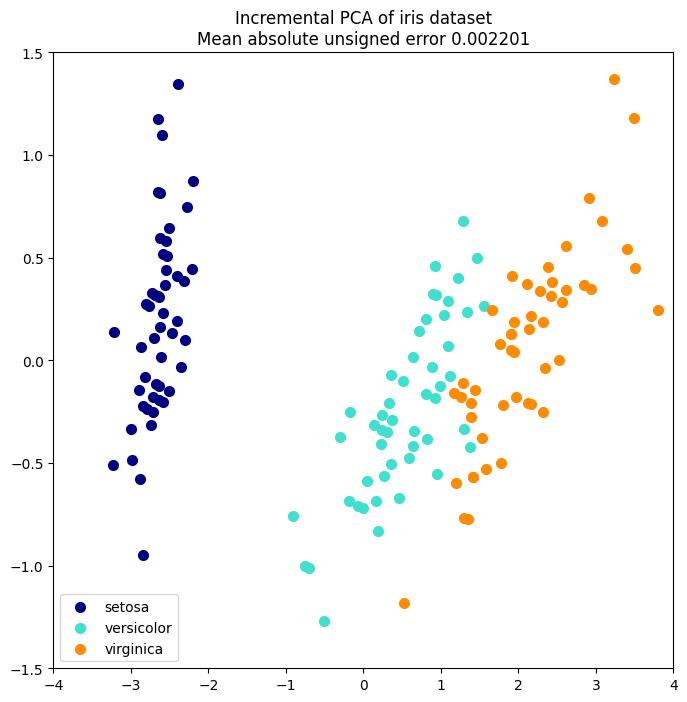

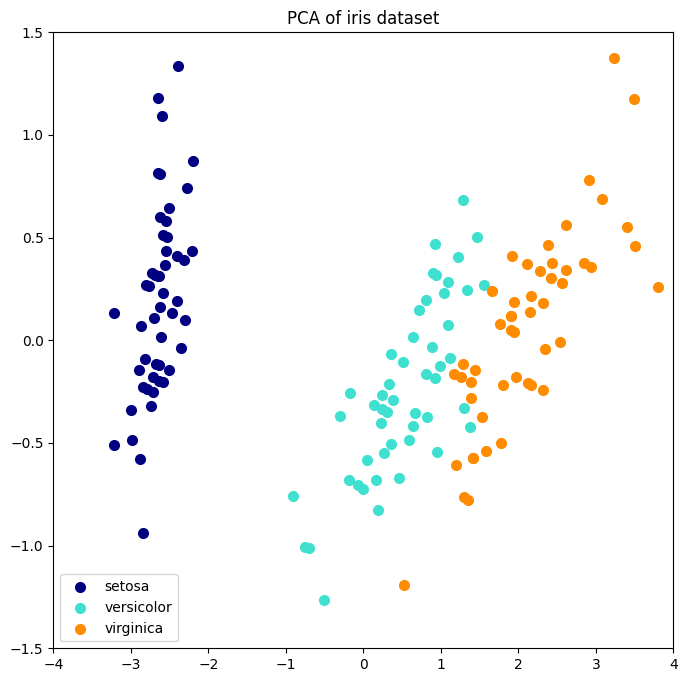

In [ ]:
# Authors: Kyle Kastner
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA

iris = load_iris()
X = iris.data
y = iris.target

n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=10)
X_ipca = ipca.fit_transform(X)

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

colors = ["navy", "turquoise", "darkorange"]

for X_transformed, title in [(X_ipca, "Incremental PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        plt.scatter(
            X_transformed[y == i, 0],
            X_transformed[y == i, 1],
            color=color,
            lw=2,
            label=target_name,
        )

    if "Incremental" in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
        plt.title(title + " of iris dataset\nMean absolute unsigned error %.6f" % err)
    else:
        plt.title(title + " of iris dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.axis([-4, 4, -1.5, 1.5])

plt.show()

# Nomor 4 Image denoising using dictionary learning

## Generate distorted image

In [ ]:
import numpy as np

try:  # Scipy >= 1.10
    from scipy.datasets import face
except ImportError:
    from scipy.misc import face

raccoon_face = face(gray=True)

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
raccoon_face = raccoon_face / 255.0

# downsample for higher speed
raccoon_face = (
    raccoon_face[::4, ::4]
    + raccoon_face[1::4, ::4]
    + raccoon_face[::4, 1::4]
    + raccoon_face[1::4, 1::4]
)
raccoon_face /= 4.0
height, width = raccoon_face.shape

# Distort the right half of the image
print("Distorting image...")
distorted = raccoon_face.copy()
distorted[:, width // 2 :] += 0.075 * np.random.randn(height, width // 2)

Distorting image...


## Display the distorted image

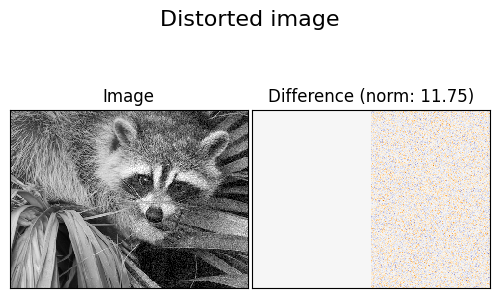

In [ ]:
import matplotlib.pyplot as plt


def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title("Difference (norm: %.2f)" % np.sqrt(np.sum(difference**2)))
    plt.imshow(
        difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation="nearest"
    )
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)


show_with_diff(distorted, raccoon_face, "Distorted image")

## Extract reference patches

In [ ]:
from time import time

from sklearn.feature_extraction.image import extract_patches_2d

# Extract all reference patches from the left half of the image
print("Extracting reference patches...")
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, : width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print(f"{data.shape[0]} patches extracted in %.2fs." % (time() - t0))

Extracting reference patches...
22692 patches extracted in 0.04s.


## Learn the dictionary from reference patches

Learning the dictionary...
1.0 iterations / 112 steps in 41.11.


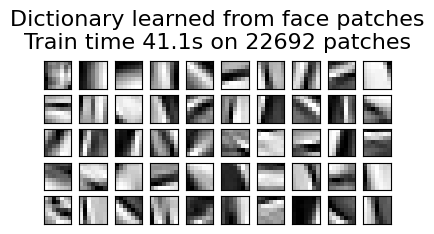

In [ ]:
from sklearn.decomposition import MiniBatchDictionaryLearning

print("Learning the dictionary...")
t0 = time()
dico = MiniBatchDictionaryLearning(
    # increase to 300 for higher quality results at the cost of slower
    # training times.
    n_components=50,
    batch_size=200,
    alpha=1.0,
    max_iter=10,
)
V = dico.fit(data).components_
dt = time() - t0
print(f"{dico.n_iter_} iterations / {dico.n_steps_} steps in {dt:.2f}.")

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    "Dictionary learned from face patches\n"
    + "Train time %.1fs on %d patches" % (dt, len(data)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

## Extract noisy patches and reconstruct them using the dictionary

In [ ]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

print("Extracting noisy patches... ")
t0 = time()
data = extract_patches_2d(distorted[:, width // 2 :], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print("done in %.2fs." % (time() - t0))

transform_algorithms = [
    ("Orthogonal Matching Pursuit\n1 atom", "omp", {"transform_n_nonzero_coefs": 1}),
    ("Orthogonal Matching Pursuit\n2 atoms", "omp", {"transform_n_nonzero_coefs": 2}),
    ("Least-angle regression\n4 atoms", "lars", {"transform_n_nonzero_coefs": 4}),
    ("Thresholding\n alpha=0.1", "threshold", {"transform_alpha": 0.1}),
]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + "...")
    reconstructions[title] = raccoon_face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == "threshold":
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2 :] = reconstruct_from_patches_2d(
        patches, (height, width // 2)
    )
    dt = time() - t0
    print("done in %.2fs." % dt)
    show_with_diff(reconstructions[title], raccoon_face, title + " (time: %.1fs)" % dt)

plt.show()

Extracting noisy patches... 
done in 0.02s.
Orthogonal Matching Pursuit
1 atom...
done in 2.19s.
Orthogonal Matching Pursuit
2 atoms...
done in 3.80s.
Least-angle regression
4 atoms...
